# Logistic Regression: weather_condition - has_fatal_injury

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

In [5]:
ak = pd.read_csv("../datasets/alaska_single_engine_clean.csv")

In [6]:
ak.shape

(5590, 41)

In [8]:
predictor = 'weather_condition'

In [9]:
target = 'has_fatal_injury'

In [10]:
ak = ak[[predictor, target]]

In [11]:
ak.columns

Index(['weather_condition', 'has_fatal_injury'], dtype='object')

## Dummify Columns

In [12]:
def dummies(df, col_inference, category_to_drop):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    columns_to_dummify_drop_first = [col for col in categorical_columns if col != col_inference]
    
    df_dummies = pd.get_dummies(df, columns=columns_to_dummify_drop_first, drop_first=True)
    
    df_dummies = pd.get_dummies(df_dummies, columns=[col_inference], drop_first=False)
    
    dummy_to_drop = f"{col_inference}_{category_to_drop}"
    if dummy_to_drop in df_dummies.columns:
        df_dummies.drop(columns=[dummy_to_drop], inplace=True)
    
    return df_dummies

In [13]:
ak_dummies_weather = dummies(ak, predictor, 'VMC')

In [14]:
ak_dummies_weather.columns

Index(['has_fatal_injury', 'weather_condition_IMC',
       'weather_condition_Unknown'],
      dtype='object')

In [15]:
ak_dummies_weather.head()

,has_fatal_injury,weather_condition_IMC,weather_condition_Unknown
0,0,0,1
1,0,0,1
2,0,0,0
3,0,0,1
4,0,0,0


## Train, Test, Split

In [16]:
X = ak_dummies_weather.drop(columns = target)
y = ak_dummies_weather[target]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21)

## Baseline

In [18]:
1 - y.mean()

0.8967799642218247

## Benchmark Logistic Regression Model

In [19]:
pipe_log_reg_bench = Pipeline([
    ('sc', StandardScaler()),
    ('log_reg_bench', LogisticRegression(max_iter=1000))
])

In [20]:
pipe_log_reg_bench.fit(X_train, y_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('log_reg_bench', LogisticRegression(max_iter=1000))])

In [21]:
pipe_log_reg_bench.score(X_train, y_train)

0.8976346650765256

In [22]:
pipe_log_reg_bench.score(X_test, y_test)

0.9069767441860465

## Tuned Logistic Regression Model

In [23]:
pipe_log_reg_tuned = Pipeline([
    ('sc', StandardScaler()),
    ('log_reg_tuned', LogisticRegression())
])

In [24]:
pipe_log_reg_tuned.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('log_reg_tuned', LogisticRegression())],
 'verbose': False,
 'sc': StandardScaler(),
 'log_reg_tuned': LogisticRegression(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'log_reg_tuned__C': 1.0,
 'log_reg_tuned__class_weight': None,
 'log_reg_tuned__dual': False,
 'log_reg_tuned__fit_intercept': True,
 'log_reg_tuned__intercept_scaling': 1,
 'log_reg_tuned__l1_ratio': None,
 'log_reg_tuned__max_iter': 100,
 'log_reg_tuned__multi_class': 'auto',
 'log_reg_tuned__n_jobs': None,
 'log_reg_tuned__penalty': 'l2',
 'log_reg_tuned__random_state': None,
 'log_reg_tuned__solver': 'lbfgs',
 'log_reg_tuned__tol': 0.0001,
 'log_reg_tuned__verbose': 0,
 'log_reg_tuned__warm_start': False}

In [25]:
pipe_log_reg_tuned_params = {
    'log_reg_tuned__max_iter': [100, 1_000],
    'log_reg_tuned__C': np.linspace(0.001, 1, 5),
    'log_reg_tuned__penalty': ['l2']
}

In [26]:
gs= GridSearchCV(pipe_log_reg_tuned,
                                param_grid = pipe_log_reg_tuned_params,
                                cv = 5,
                               n_jobs=6)

In [27]:
%%time
gs.fit(X_train, y_train)

Wall time: 2.16 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('log_reg_tuned',
                                        LogisticRegression())]),
             n_jobs=6,
             param_grid={'log_reg_tuned__C': array([0.001  , 0.25075, 0.5005 , 0.75025, 1.     ]),
                         'log_reg_tuned__max_iter': [100, 1000],
                         'log_reg_tuned__penalty': ['l2']})

In [28]:
gs.best_params_

{'log_reg_tuned__C': 0.25075,
 'log_reg_tuned__max_iter': 100,
 'log_reg_tuned__penalty': 'l2'}

In [29]:
gs.score(X_train, y_train)

0.8976346650765256

In [30]:
gs.score(X_test, y_test)

0.9069767441860465

In [31]:
y_pred = gs.predict(X_test)

In [32]:
confusion_matrix(y_test, y_pred)

array([[500,   4],
       [ 48,   7]], dtype=int64)

In [50]:
    def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
      
        matrix = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10,7))
        sns.heatmap(matrix, annot=True, fmt='g', cmap="Blues", 
                    xticklabels=['Predicted No Fatalities', 'Predicted Fatalities'], 
                    yticklabels=['Actually No Fatalities', 'Actually Had Fatalities'])
        plt.title(title)
        plt.show()

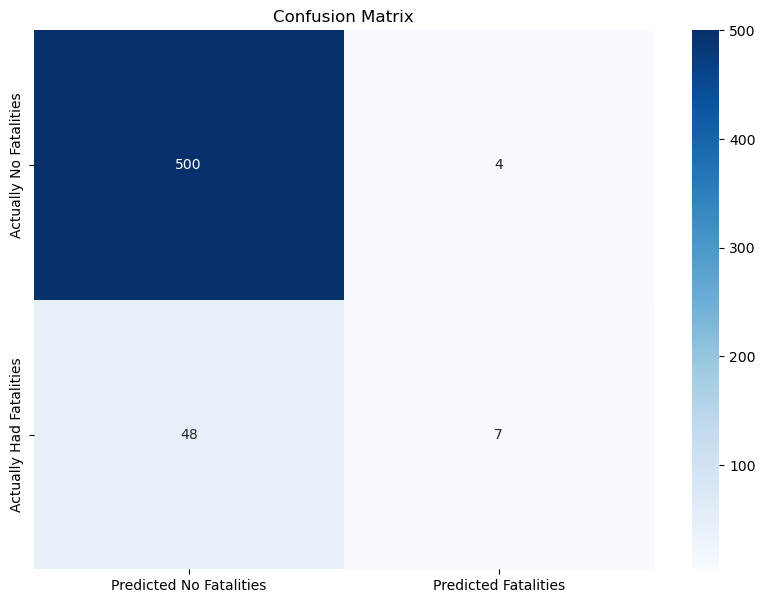

In [51]:
plot_confusion_matrix(y_test, y_pred)

In [53]:
conf_mat = confusion_matrix(y, gs.predict(X))
print('Precision', conf_mat[0, 0] / sum(conf_mat[:, 0]))
print('Recall', conf_mat[0, 0] / sum(conf_mat[0, :]))
print('Specificity', conf_mat[1, 1] / sum(conf_mat[1, :]))

Precision 0.9044759825327511
Recall 0.9916217833632556
Specificity 0.09012131715771231


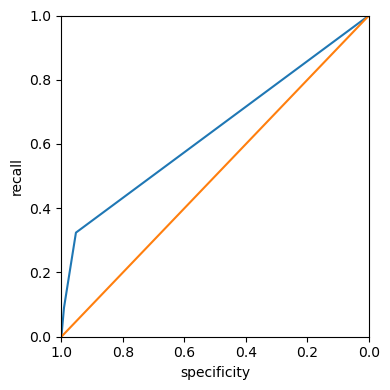

In [56]:
fpr, tpr, thresholds = roc_curve(y, gs.predict_proba(X)[:, 1], pos_label=1)
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')


plt.tight_layout()
plt.show()

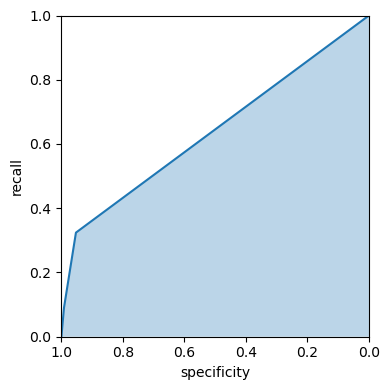

In [58]:
fpr, tpr, thresholds = roc_curve(y, gs.predict_proba(X)[:,1], pos_label=1)
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)

ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()

In [33]:
print(classification_report(y_test, y_pred, digits = 5))

              precision    recall  f1-score   support

           0    0.91241   0.99206   0.95057       504
           1    0.63636   0.12727   0.21212        55

    accuracy                        0.90698       559
   macro avg    0.77439   0.55967   0.58135       559
weighted avg    0.88525   0.90698   0.87791       559



## Coefficients

In [34]:
feature_names = list(X_train.columns)

In [35]:
coef_log_odds = gs.best_estimator_.named_steps['log_reg_tuned'].coef_[0]

In [36]:
coef_odds = np.exp(gs.best_estimator_.named_steps['log_reg_tuned'].coef_[0])

In [37]:
coef_log_odds_df = pd.DataFrame({'feature': feature_names, 'coefficient': coef_log_odds})

In [38]:
coef_odds_df = pd.DataFrame({'feature': feature_names, 'coefficient': coef_odds})

In [39]:
pd.set_option('display.max_rows', None)
coef_log_odds_df.head()

,feature,coefficient
0,weather_condition_IMC,0.515280
1,weather_condition_Unknown,0.339314


In [40]:
pd.set_option('display.max_rows', None)
coef_odds_df.head()

,feature,coefficient
0,weather_condition_IMC,1.674108
1,weather_condition_Unknown,1.403984


In [41]:
# file_name = f"../../datasets/nolan_logreg_{predictor}-{target}_coef.csv"

# coef_log_odds_df.to_csv(file_name, index=False)

OSError: Cannot save file into a non-existent directory: '..\..\datasets'

## Pickle

In [38]:
# file_name = f"../../pickles/nolan_logreg_{predictor}-{target}.pkl"

# with open(file_name, 'wb') as f:
#     pickle.dump(gs, f) 